In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
import pickle

In [68]:
train_xf1 = pd.read_pickle('/home/kai/data/shiyi/xunfei/train1.pkl')

test_xf1 = pd.read_pickle('/home/kai/data/shiyi/xunfei/test1.pkl')

In [2]:
train_bo2 = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/added/train_comb_bo2_op5f4_simfe_corr1549_added.pkl')
test_bo2 = pd.read_pickle('/home/kai/data/shiyi/homecreditdata/added/test_comb_bo2_op5f4_simfe_corr1549_added.pkl')

train_bo2.SK_ID_CURR = train_bo2.SK_ID_CURR.astype(int)
test_bo2.SK_ID_CURR = test_bo2.SK_ID_CURR.astype(int)

In [3]:
train_bo2_ori = pd.read_pickle('/home/kai/data/shiyi/data/home_credit/train_bo2.pkl')
test_bo2_ori = pd.read_pickle('/home/kai/data/shiyi/data/home_credit/test_bo2.pkl')
train_bo2_ori.SK_ID_CURR = train_bo2_ori.SK_ID_CURR.astype(int)
test_bo2_ori.SK_ID_CURR = test_bo2_ori.SK_ID_CURR.astype(int)

In [3]:
from pandas.api.types import CategoricalDtype
cat_cols = []
for col in test_bo2.columns:
    if isinstance(test_bo2[col].dtype, CategoricalDtype):# and test_bo2[col].dtype!=int:
        cat_cols.append(col)
        print(col)

len(cat_cols)

Bureau_balance_Last_STATUS_category
BU_CREDIT_TYPE_category


2

In [4]:
train_bo2.drop(columns=cat_cols, inplace=True)
test_bo2.drop(columns=cat_cols, inplace=True)

In [5]:
train_bo2.dtypes.value_counts()

float64    1111
float32     334
uint8        80
int64        44
dtype: int64

In [6]:
cat_cols = []
for col in tqdm(test_bo2.columns):
    n = train_bo2[col].nunique()
    if n<10:
        cat_cols.append(col)

100%|██████████| 1568/1568 [00:04<00:00, 358.11it/s]


In [8]:
# cat_cols.remove('TARGET')                                                                                

In [7]:
len(cat_cols)

173

In [8]:
import copy
train_count = copy.copy(train_bo2)
test_count = copy.copy(test_bo2)
train_count = train_count.replace([-np.inf, np.inf], np.nan)
test_count = test_count.replace([-np.inf, np.inf], np.nan)
train_count[cat_cols] = train_count[cat_cols].fillna(-99999)
test_count[cat_cols] = test_count[cat_cols].fillna(-99999)
train_count["test"]=0
test_count["test"]=1
temp_df = pd.concat([train_count,test_count],axis=0)
for col in tqdm(cat_cols):
    temp_df.loc[:,col]=temp_df.loc[:,col].astype('category')
train_count=temp_df[temp_df["test"]==0].drop(columns=['test'])
test_count=temp_df[temp_df["test"]==1].drop(columns=['test'])

100%|██████████| 173/173 [00:17<00:00,  9.85it/s]


In [9]:
for col in tqdm(cat_cols):
#     counts = train_count.iloc[:,i].value_counts()
    counts = train_count[col].value_counts()
    counts = counts.sort_index()
    counts = counts.fillna(0)
    counts += np.random.rand(len(counts))/1000
    train_count.loc[:,col].cat.categories = counts
    test_count.loc[:,col].cat.categories = counts

for col in cat_cols:
    train_count[col] = train_count[col].astype(float)
    test_count[col] = test_count[col].astype(float)

num_cols = [col for col in test_count.columns if col not in cat_cols]
train_count[num_cols] = train_count[num_cols].fillna(0)

100%|██████████| 173/173 [00:00<00:00, 502.79it/s]


In [10]:
train_bo2[cat_cols[0]].value_counts()

0.0    264503
1.0      1292
2.0       106
3.0        45
4.0        26
5.0         9
6.0         8
9.0         2
8.0         1
Name: AMT_REQ_CREDIT_BUREAU_DAY_x, dtype: int64

In [11]:
train_count[cat_cols[0]].value_counts()

264503.000669    264503
41519.000998      41519
1292.000748        1292
106.000742          106
45.000825            45
26.000490            26
9.000145              9
8.000047              8
2.000542              2
1.000054              1
Name: AMT_REQ_CREDIT_BUREAU_DAY_x, dtype: int64

In [12]:
train_p = train_count
X = train_p.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_p['TARGET']

In [13]:
clf = RidgeClassifier()

In [66]:
# train_s = train_bo2.replace([-np.inf, np.inf], np.nan)
# train_s = train_s.fillna(0)

# max_v = {}
# min_v = {}
# for col in tqdm(train_s.columns):
#     max_v[col] = train_s[col].max()
#     min_v[col] = train_s[col].min()

# np.max(list(max_v.values())), np.min(list(min_v.values()))

# scores = cross_val_score(clf, train_s.drop(columns=['TARGET', 'SK_ID_CURR']), train_s['TARGET'], cv=5, scoring='roc_auc')
# scores = scores.mean()

In [14]:
feats = pickle.load(open('feats_1549.pkl', 'rb'))

In [15]:
feats[:5]

['AMT_CREDIT_divide_AMT_ANNUITY',
 'external_sources_max',
 'external_sources_min',
 'DAYS_BIRTH_x',
 'bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_DEBT_min']

In [83]:
train_count['DAYS_ID_PUBLISH_x'].describe()

count    307511.000000
mean      -2994.202373
std        1509.450419
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH_x, dtype: float64

In [17]:
i = 3
init_feats = feats[:i]
init_score = cross_val_score(clf, X[init_feats], y, cv=5, scoring='roc_auc')
init_score = init_score.mean()
print('init auc: ', init_score)
i = 3

featlist = feats[i:]
# for i, feat in enumerate(featlist):
while i < len(featlist):
    feat = featlist[i]
    i+=1
    try:
        scores = cross_val_score(clf, X[init_feats+[feat]], y, cv=5, scoring='roc_auc')#, n_jobs=18)
        auc = scores.mean()
        if auc > init_score:
            init_score = auc
            init_feats = init_feats+[feat]
            print('#{}/{} | YES! {} [{}] {:.6f}'.format(i, len(featlist), feat, len(init_feats), init_score))
        else:
            print('#{}/{} | NO!! {} [{}] {:.6f}'.format(i, len(featlist), feat, len(init_feats), init_score))
        time.sleep(1)

    except:
        print('EXCEPTION!!! {}'.format(feat))

init auc:  0.7144807212447646
#4/1565 | YES! AMT_CREDIT_divide_AMT_GOODS_PRICE [4] 0.720527
#5/1565 | NO!! Wei_EXT_SOURCE_2_x==DEVIDE==AMT_CREDIT [4] 0.720527
#6/1565 | YES! EXT_SOURCE_3_x [5] 0.722924
#7/1565 | YES! Wei_Remaining_AMT_Payment_LAST [6] 0.723478
#8/1565 | NO!! Wei_EXT_SOURCE_1_x==DEVIDE==AMT_CREDIT [6] 0.723478
#9/1565 | YES! NAME_EDUCATION_TYPE_CODE_GENDER_AMT_ANNUITY_max_diff [7] 0.727339
#10/1565 | NO!! bureau_agg__AMT_CREDIT_SUM_divide_DAYS_CREDIT_max_minus_min [7] 0.727339
#11/1565 | YES! inst_AMT_CUM_PAYMENT_sum [8] 0.727380
#12/1565 | YES! Wei_Remaining_AMT_Payment_TOTAL [9] 0.727753
#13/1565 | YES! EXT_SOURCE_1_x [10] 0.728857
#14/1565 | YES! inst_RATE_RATE_LATE_PAYMENT_mean [11] 0.730071
#15/1565 | NO!! NAME_EDUCATION_TYPE_CODE_GENDER_EXT_SOURCE_1_mean_abs_diff [11] 0.730071
#16/1565 | YES! AMT_ANNUITY_x [12] 0.730071
#17/1565 | NO!! Wei_EXT_SOURCE_3_x==DEVIDE==AMT_CREDIT [12] 0.730071
#18/1565 | YES! bureau_DAYS_CREDIT_ENDDATE_max [13] 0.730085
#19/1565 | YES! 

#119/1565 | YES! bureau_agg__AMT_CREDIT_SUM_DEBT_divide_DAYS_CREDIT_max_minus_min [86] 0.756261
#120/1565 | YES! bureau_agg__DAYS_CREDIT_standard_error [87] 0.756320
#121/1565 | YES! prev_AMT_ANNUITY_divide_AMT_DOWN_PAYMENT_mean [88] 0.756322
#122/1565 | YES! bureau_AMT_CREDIT_SUM_divide_DAYS_CREDIT_ENDDATE_mean [89] 0.756329
#123/1565 | YES! AMT_CREDIT_divide_DAYS_BIRTH [90] 0.756393
#124/1565 | YES! inst_RATE_EARLY_DAYS_SIGN_min [91] 0.756576
#125/1565 | YES! prev_AMT_APPLICATION_divide_AMT_DOWN_PAYMENT_min [92] 0.756586
#126/1565 | YES! prev_AMT_ANNUITY_divide_DAYS_LAST_DUE_1ST_VERSION_max [93] 0.756592
#127/1565 | YES! prev_AMT_ANNUITY_divide_DAYS_LAST_DUE_1ST_VERSION_minus_DAYS_LAST_DUE_min [94] 0.756637
#128/1565 | NO!! inst_agg__DAYS_ENTRY_PAYMENT_two_minus_one_third [94] 0.756637
#129/1565 | YES! prev_AMT_APPLICATION_divide_DAYS_FIRST_DRAWING_minus_DAYS_FIRST_DUE_mean [95] 0.756655
#130/1565 | NO!! REGION_POPULATION_RELATIVE_x [95] 0.756655
#131/1565 | YES! inst_DAYS_INSTALMENT

#227/1565 | NO!! NAME_EDUCATION_TYPE_CODE_GENDER_DAYS_REGISTRATION_mean_abs_diff [148] 0.765861
#228/1565 | YES! CODE_GENDER_x [149] 0.766054
#229/1565 | NO!! prev_DAYS_FIRST_DUE_min [149] 0.766054
#230/1565 | NO!! prev_AMT_ANNUITY_divide_AMT_DOWN_PAYMENT_min [149] 0.766054
#231/1565 | NO!! last_10by100_fraction_installment_paid_late_in_days_iqr [149] 0.766054
#232/1565 | YES! inst_agg__DAYS_ENTRY_PAYMENT_minus_DAYS_INSTALMENT_divide_AMT_INSTALMENT_minus_AMT_PAYMENT_two_minus_one_third [150] 0.766055
#233/1565 | NO!! last_5by50_fraction_installment_paid_late_in_days_mean [150] 0.766055
#234/1565 | YES! inst_AMT_ONTIME_PAYMENT_divide_AMT_INSTALMENT_sum [151] 0.766079
#235/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_FIRST_DRAWING_minus_DAYS_LAST_DUE_1ST_VERSION_median [151] 0.766079
#236/1565 | YES! PREV_APP_CREDIT_PERC_VAR [152] 0.766082
#237/1565 | YES! prev_AMT_ANNUITY_divide_DAYS_DECISION_max [153] 0.766091
#238/1565 | YES! inst_RATE_RATE_LATE_PAYMENT_sum [154] 0.766305
#239/1565 | 

#333/1565 | YES! PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN [204] 0.770389
#334/1565 | NO!! prev_AMT_ANNUITY_divide_DAYS_FIRST_DUE_minus_DAYS_LAST_DUE_max [204] 0.770389
#335/1565 | YES! bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_OVERDUE_max [205] 0.770570
#336/1565 | YES! prev_AMT_APPLICATION_divide_DAYS_LAST_DUE_1ST_VERSION_minus_DAYS_LAST_DUE_mean [206] 0.770576
#337/1565 | YES! bureau_DAYS_CREDIT_ENDDATE_min [207] 0.770585
#338/1565 | NO!! REFUSED_HOUR_APPR_PROCESS_START_MIN [207] 0.770585
#339/1565 | YES! bureau_credit_enddate_percentage [208] 0.770667
#340/1565 | YES! BURO_CREDIT_TYPE_Consumer credit_MEAN [209] 0.770667
#341/1565 | YES! bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_OVERDUE_sum [210] 0.770716
#342/1565 | NO!! prev_AMT_ANNUITY_divide_DAYS_FIRST_DRAWING_minus_DAYS_FIRST_DUE_min [210] 0.770716
#343/1565 | YES! NAME_FAMILY_STATUS_CODE_GENDER_CNT_CHILDREN_max_diff [211] 0.770798
#344/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_FIRST_DUE_mean [211] 0.770798
#345/1

#436/1565 | YES! inst_AMT_CUM_PAYMENT_mean [251] 0.773381
#437/1565 | NO!! all_installment_NUM_INSTALMENT_VERSION_kurt [251] 0.773381
#438/1565 | NO!! count_prev_std [251] 0.773381
#439/1565 | YES! count_CODE_GENDER_NAME_EDUCATION_TYPE [252] 0.773412
#440/1565 | NO!! prev_AMT_ANNUITY_divide_DAYS_TERMINATION_min [252] 0.773412
#441/1565 | NO!! inst_slope_RATE_LATE_PAYMENT_max_max [252] 0.773412
#442/1565 | YES! APPROVED_AMT_APPLICATION_MEAN [253] 0.773426
#443/1565 | NO!! last_20_installment_paid_late_in_days_iqr [253] 0.773426
#444/1565 | YES! DEF_30_CNT_SOCIAL_CIRCLE_divide_OBS_30_CNT_SOCIAL_CIRCLE [254] 0.773682
#445/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_FIRST_DUE_minus_DAYS_LAST_DUE_median [254] 0.773682
#446/1565 | YES! prev_DAYS_DECISION_sum [255] 0.773686
#447/1565 | NO!! prev_AMT_ANNUITY_divide_DAYS_LAST_DUE_max [255] 0.773686
#448/1565 | NO!! prev_AMT_APPLICATION_mean [255] 0.773686
#449/1565 | YES! last_10_installment_paid_late_in_days_iqr [256] 0.773695
#450/1565 | NO!

#539/1565 | YES! BURO_CREDIT_TYPE_Mortgage_MEAN [294] 0.774800
#540/1565 | NO!! inst_AMT_LATE_PAYMENT_std [294] 0.774800
#541/1565 | NO!! last_10_installment_paid_late_in_days_sum [294] 0.774800
#542/1565 | NO!! prev_AMT_DOWN_PAYMENT_divide_DAYS_TERMINATION_mean [294] 0.774800
#543/1565 | YES! NAME_EDUCATION_TYPE_CODE_GENDER_CNT_CHILDREN_max_diff [295] 0.774811
#544/1565 | NO!! last_5_installment_paid_late_in_days_kurt [295] 0.774811
#545/1565 | YES! bureau_AMT_CREDIT_MAX_OVERDUE_divide_DAYS_CREDIT_ENDDATE_median [296] 0.774812
#546/1565 | YES! req_total [297] 0.774823
#547/1565 | NO!! prev_AMT_ANNUITY_divide_DAYS_FIRST_DRAWING_minus_DAYS_LAST_DUE_mean [297] 0.774823
#548/1565 | YES! last_30_pos_cash_paid_late_count [298] 0.774926
#549/1565 | NO!! inst_RATE_LATE_DAYS_SIGN_min [298] 0.774926
#550/1565 | NO!! last_20by100_fraction_installment_paid_late_in_days_mean [298] 0.774926
#551/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_FIRST_DUE_minus_DAYS_TERMINATION_mean [298] 0.774926
#552/1

#645/1565 | YES! last_10by50_fraction_installment_paid_over_amount_skew [326] 0.776071
#646/1565 | NO!! last_20by100_fraction_NUM_INSTALMENT_VERSION_kurt [326] 0.776071
#647/1565 | YES! bureau_onehot_CREDIT_TYPE_Credit card [327] 0.776076
#648/1565 | YES! OCCUPATION_TYPE_Core staff [328] 0.776202
#649/1565 | NO!! NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_ELEVATORS_AVG_mean_abs_diff [328] 0.776202
#650/1565 | YES! PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN [329] 0.776284
#651/1565 | YES! OBS_60_CNT_SOCIAL_CIRCLE_divide_DEF_30_CNT_SOCIAL_CIRCLE [330] 0.776326
#652/1565 | YES! PREV_CHANNEL_TYPE_Channel of corporate sales_MEAN [331] 0.776404
#653/1565 | YES! bureau_AMT_CREDIT_SUM_divide_AMT_CREDIT_SUM_LIMIT_mean [332] 0.776407
#654/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_DECISION_max [332] 0.776407
#655/1565 | NO!! last_10by50_fraction_NUM_INSTALMENT_VERSION_std [332] 0.776407
#656/1565 | YES! PREV_NAME_CLIENT_TYPE_Refreshed_MEAN [333] 0.776436
#657/1565 | NO!! pr

#750/1565 | NO!! PREV_CODE_REJECT_REASON_SCOFR_MEAN [364] 0.777036
#751/1565 | NO!! bureau_onehot_STATUS_X_mean [364] 0.777036
#752/1565 | YES! PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN [365] 0.777045
#753/1565 | YES! last_5_installment_paid_late_in_days_min [366] 0.777060
#754/1565 | NO!! PREV_NAME_YIELD_GROUP_low_normal_MEAN [366] 0.777060
#755/1565 | NO!! bureau_MONTHS_BALANCE_max_min [366] 0.777060
#756/1565 | NO!! creditcard_AMT_CREDIT_LIMIT_ACTUAL_divide_AMT_DRAWINGS_CURRENT_std [366] 0.777060
#757/1565 | NO!! prev_AMT_APPLICATION_divide_DAYS_FIRST_DUE_minus_DAYS_LAST_DUE_max [366] 0.777060
#758/1565 | YES! creditcard_AMT_BALANCE_divide_CNT_DRAWINGS_POS_CURRENT_std [367] 0.777075
#759/1565 | NO!! PREV_NAME_YIELD_GROUP_middle_MEAN [367] 0.777075
#760/1565 | YES! bureau_onehot_CREDIT_ACTIVE_Closed [368] 0.777147
#761/1565 | NO!! NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_CNT_CHILDREN_max_diff [368] 0.777147
#762/1565 | NO!! last_5by50_fraction_NUM_INSTALMENT_VERSION_skew [368] 0.7771

#854/1565 | NO!! inst_positivecount_EARLY_DAYS_SIGN_mean [399] 0.778447
#855/1565 | NO!! INSTAL_DPD_SUM [399] 0.778447
#856/1565 | NO!! creditcard_AMT_PAYMENT_CURRENT_divide_CNT_DRAWINGS_ATM_CURRENT_mean [399] 0.778447
#857/1565 | NO!! prev_DAYS_LAST_DUE_minus_DAYS_TERMINATION_median [399] 0.778447
#858/1565 | YES! creditcard_AMT_DRAWINGS_CURRENT_divide_CNT_DRAWINGS_POS_CURRENT_sum [400] 0.778480
#859/1565 | NO!! creditcard_AMT_PAYMENT_CURRENT_divide_CNT_DRAWINGS_CURRENT_mean [400] 0.778480
#860/1565 | NO!! bureau_onehot_STATUS_C_mean [400] 0.778480
#861/1565 | YES! NAME_INCOME_TYPE_x [401] 0.778507
#862/1565 | NO!! bureau_AMT_CREDIT_SUM_LIMIT_divide_DAYS_CREDIT_ENDDATE_mean [401] 0.778507
#863/1565 | YES! last_20_installment_paid_over_amount_iqr [402] 0.778509
#864/1565 | NO!! inst_positivecount_EARLY_DAYS_SIGN_std [402] 0.778509
#865/1565 | NO!! bureau_AMT_ANNUITY_divide_DAYS_CREDIT_UPDATE_median [402] 0.778509
#866/1565 | NO!! last_20by100_fraction_installment_paid_late_in_days_min 

#962/1565 | NO!! prev_DAYS_FIRST_DUE_minus_DAYS_LAST_DUE_1ST_VERSION_max [427] 0.778885
#963/1565 | NO!! PREV_NAME_GOODS_CATEGORY_Furniture_MEAN [427] 0.778885
#964/1565 | NO!! bureau_AMT_CREDIT_SUM_LIMIT_divide_AMT_CREDIT_SUM_OVERDUE_mean [427] 0.778885
#965/1565 | NO!! inst_RATE_AMT_CUM_PAYMENT_max [427] 0.778885
#966/1565 | YES! bureau_AMT_CREDIT_SUM_OVERDUE_divide_CNT_CREDIT_PROLONG_mean [428] 0.778919
#967/1565 | NO!! 6_period_trend_SK_DPD [428] 0.778919
#968/1565 | YES! BURO_STATUS_1_MEAN_MEAN [429] 0.778938
#969/1565 | NO!! creditcard_AMT_DRAWINGS_CURRENT_divide_AMT_RECIVABLE_sum [429] 0.778938
#970/1565 | NO!! last_12_SK_DPD_DEF_skew [429] 0.778938
#971/1565 | NO!! ACTIVE_MONTHS_BALANCE_SIZE_SUM [429] 0.778938
#972/1565 | NO!! REFUSED_RATE_DOWN_PAYMENT_MIN [429] 0.778938
#973/1565 | NO!! creditcard_AMT_PAYMENT_CURRENT_divide_CNT_DRAWINGS_CURRENT_median [429] 0.778938
#974/1565 | NO!! COMMONAREA_AVG_x [429] 0.778938
#975/1565 | YES! diff_def_sum_mean [430] 0.778950
#976/1565 | N

#1071/1565 | NO!! creditcard_AMT_PAYMENT_CURRENT_divide_CNT_DRAWINGS_POS_CURRENT_median [458] 0.779715
#1072/1565 | NO!! creditcard_AMT_DRAWINGS_CURRENT_divide_AMT_PAYMENT_CURRENT_mean [458] 0.779715
#1073/1565 | YES! PREV_CHANNEL_TYPE_Stone_MEAN [459] 0.779720
#1074/1565 | YES! PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN [460] 0.779731
#1075/1565 | YES! last_5by50_fraction_installment_paid_over_amount_min [461] 0.779748
#1076/1565 | NO!! last_20by100_fraction_installment_paid_over_amount_sum [461] 0.779748
#1077/1565 | NO!! prev_onehot_FLAG_NAME_CASH_LOAN_PURPOSE_2.0 [461] 0.779748
#1078/1565 | NO!! prev_onehot_CODE_REJECT_REASON_SCOFR [461] 0.779748
#1079/1565 | NO!! last_5by20_fraction_NUM_INSTALMENT_VERSION_max [461] 0.779748
#1080/1565 | YES! last_5by20_fraction_installment_paid_over_amount_mean [462] 0.779751
#1081/1565 | YES! last_5by20_fraction_installment_paid_over_amount_median [463] 0.779752
#1082/1565 | YES! prev_AMT_APPLICATION_divide_AMT_GOODS_PRICE_mean [464] 0.779766
#108

#1185/1565 | NO!! prev_onehot_CHANNEL_TYPE_Channel of corporate sales [493] 0.780354
#1186/1565 | YES! prev_onehot_CHANNEL_TYPE_Contact center [494] 0.780384
#1187/1565 | YES! AMT_REQ_CREDIT_BUREAU_DAY_divide_DAYS_EMPLOYED [495] 0.780384
#1188/1565 | YES! last_12_SK_DPD_std [496] 0.780387
#1189/1565 | NO!! PREV_CODE_REJECT_REASON_LIMIT_MEAN [496] 0.780387
#1190/1565 | NO!! prev_onehot_CODE_REJECT_REASON_SCO [496] 0.780387
#1191/1565 | NO!! prev_onehot_NAME_CONTRACT_TYPE_Revolving loans [496] 0.780387
#1192/1565 | NO!! creditcard_AMT_BALANCE_divide_AMT_PAYMENT_CURRENT_sum [496] 0.780387
#1193/1565 | YES! prev_onehot_CHANNEL_TYPE_Credit and cash offices [497] 0.780393
#1194/1565 | NO!! PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN [497] 0.780393
#1195/1565 | NO!! creditcard_AMT_CREDIT_LIMIT_ACTUAL_divide_CNT_DRAWINGS_OTHER_CURRENT_std [497] 0.780393
#1196/1565 | NO!! creditcard_AMT_DRAWINGS_CURRENT_divide_CNT_DRAWINGS_ATM_CURRENT_std [497] 0.780393
#1197/1565 | NO!! last_12_SK_DPD_skew [497] 0

#1295/1565 | NO!! PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN [519] 0.780730
#1296/1565 | YES! PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN [520] 0.780734
#1297/1565 | YES! unique_NAME_INCOME_TYPE_y [521] 0.780761
#1298/1565 | NO!! PREV_NAME_TYPE_SUITE_Other_B_MEAN [521] 0.780761
#1299/1565 | NO!! creditcard_SK_DPD_divide_CNT_DRAWINGS_ATM_CURRENT_mean [521] 0.780761
#1300/1565 | YES! bureau_AMT_CREDIT_SUM_LIMIT_divide_DAYS_CREDIT_UPDATE_median [522] 0.780763
#1301/1565 | YES! NAME_FAMILY_STATUS_x [523] 0.780764
#1302/1565 | YES! NAME_HOUSING_TYPE_Municipal apartment [524] 0.780765
#1303/1565 | NO!! bureau_onehot_STATUS_0_min [524] 0.780765
#1304/1565 | NO!! onehot_NAME_CONTRACT_STATUS_Completed [524] 0.780765
#1305/1565 | NO!! bureau_STATUS_NUM_divide_MONTHS_BALANCE_min_max [524] 0.780765
#1306/1565 | NO!! NAME_TYPE_SUITE_x [524] 0.780765
#1307/1565 | NO!! bureau_AMT_CREDIT_SUM_LIMIT_divide_DAYS_CREDIT_median [524] 0.780765
#1308/1565 | NO!! last_5by50_fraction_NUM_INSTALMENT_VERSION

#1408/1565 | YES! NAME_FAMILY_STATUS_Civil marriage [547] 0.781000
#1409/1565 | NO!! all_installment_NUM_INSTALMENT_VERSION_min [547] 0.781000
#1410/1565 | NO!! bureau_AMT_CREDIT_SUM_LIMIT_divide_DAYS_ENDDATE_FACT_max [547] 0.781000
#1411/1565 | NO!! bureau_AMT_CREDIT_SUM_LIMIT_divide_DAYS_ENDDATE_FACT_median [547] 0.781000
#1412/1565 | NO!! bureau_AMT_CREDIT_SUM_OVERDUE_divide_AMT_ANNUITY_max [547] 0.781000
#1413/1565 | NO!! bureau_AMT_CREDIT_SUM_OVERDUE_divide_AMT_ANNUITY_mean [547] 0.781000
#1414/1565 | NO!! bureau_CNT_CREDIT_PROLONG_max [547] 0.781000
#1415/1565 | NO!! bureau_CNT_CREDIT_PROLONG_mean [547] 0.781000
#1416/1565 | NO!! CNT_CHILDREN_x [547] 0.781000
#1417/1565 | YES! CLOSED_MONTHS_BALANCE_MAX_MAX [548] 0.781013
#1418/1565 | NO!! CLOSED_AMT_CREDIT_SUM_LIMIT_SUM [548] 0.781013
#1419/1565 | NO!! NAME_TYPE_SUITE_Children [548] 0.781013
#1420/1565 | NO!! NAME_TYPE_SUITE_Family [548] 0.781013
#1421/1565 | NO!! CC_SK_DPD_DEF_MAX [548] 0.781013
#1422/1565 | NO!! CC_NAME_CONTRAC

#1528/1565 | NO!! last_1_NUM_INSTALMENT_VERSION_skew [581] 0.781661
#1529/1565 | NO!! FONDKAPREMONT_MODE_reg oper spec account [581] 0.781661
#1530/1565 | NO!! PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN [581] 0.781661
#1531/1565 | NO!! last_5by50_fraction_installment_paid_over_amount_max [581] 0.781661
#1532/1565 | NO!! last_1_NUM_INSTALMENT_VERSION_iqr [581] 0.781661
#1533/1565 | YES! BURO_CREDIT_TYPE_Loan for business development_MEAN [582] 0.781664
#1534/1565 | YES! ORGANIZATION_TYPE_Hotel [583] 0.781681
#1535/1565 | NO!! FLAG_DOCUMENT_4 [583] 0.781681
#1536/1565 | NO!! last_1_installment_paid_over_count [583] 0.781681
#1537/1565 | YES! CC_CNT_DRAWINGS_POS_CURRENT_MIN [584] 0.781683
#1538/1565 | NO!! WEEKDAY_APPR_PROCESS_START_SATURDAY [584] 0.781683
#1539/1565 | NO!! WALLSMATERIAL_MODE_Wooden [584] 0.781683
#1540/1565 | NO!! AMT_REQ_CREDIT_BUREAU_HOUR_divide_OWN_CAR_AGE [584] 0.781683
#1541/1565 | NO!! last_1_installment_paid_over_amount_iqr [584] 0.781683
#1542/1565 | YES!

In [71]:
scores

0.7632086321433419

In [18]:
len(init_feats)

587

In [40]:
feats_set2 = list(set(init_feats).union(feats[:587]))

In [19]:
pickle.dump(init_feats, open('1549_ridge.pkl', 'wb'))

In [20]:
'TARGET' in init_feats

False

In [98]:
test_df = test_xf1

train_xf1['_temp_day'] = train_xf1.time_day.astype(int)
holdout_df = train_xf1[train_xf1['_temp_day']==157211].drop(columns='_temp_day')
train_df = train_xf1[train_xf1['time_day']!=157211].drop(columns='_temp_day')

print(int(train_df['click'].mean()*10000), int(holdout_df['click'].mean()*10000))

1984 2071


In [96]:
test_df = test_xf1

train_df, holdout_df = train_test_split(train_xf1.drop(columns='_temp_day'), test_size=1/1000, random_state=4)
print(int(train_df['click'].mean()*10000), int(holdout_df['click'].mean()*10000))

1984 1676


In [8]:
def sel_na(X, na_thresh):
    X_na = (X.isnull().sum() / len(X))#.sort_values(ascending = False)
    return X_na.index[X_na <= na_thresh]

In [ ]:
sel_na_cols = sel_na(train_df, 0.95)

In [10]:
def sel_corr_todrop(X, thresh, upper):
    if upper is None:
        corr_matrix = X.corr().abs()
        # Upper triangle of correlations
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        pickle.dump(upper, open('upper.pkl', 'wb'))
    return [column for column in upper.columns if any(upper[column] > thresh)] 

In [11]:
upper = pickle.load(open('bo2_upper.pkl', 'rb'))

In [13]:
corr_drop = sel_corr_todrop(train_df, 0.99, upper)

In [17]:
train_df = train_df.drop(columns=corr_drop)
holdout_df = holdout_df.drop(columns=corr_drop)

test_df = test_bo2_ori.drop(columns=corr_drop)

(263580, 589) (48744, 588) (43931, 589)
MEAN: train(263580) vs holdout(43931):  0.08067000531148039 0.08108169629646492
computing optimal rounds...
[0]	train-auc:0.661473+0.00238625	test-auc:0.652233+0.00489419
[100]	train-auc:0.829123+0.000560302	test-auc:0.783813+0.00404166
[200]	train-auc:0.860692+0.00088934	test-auc:0.78874+0.00387235
[300]	train-auc:0.88189+0.000968416	test-auc:0.789686+0.00408696
[400]	train-auc:0.898753+0.00102563	test-auc:0.789605+0.00416117
[500]	train-auc:0.912815+0.00107323	test-auc:0.789373+0.00406015
xgb cv te:  0.789713  tr:  0.8940672
best rounds:  371
[0]	val-auc:0.648552
[100]	val-auc:0.783288
[200]	val-auc:0.787972
[300]	val-auc:0.788087
[370]	val-auc:0.788561
Fold  1 [  371] AUC : ho: 0.788383 / te: 0.788561 / tr: -1.000000 (diff: 0.000179)
[0]	val-auc:0.649528
[100]	val-auc:0.781013
[200]	val-auc:0.786075
[300]	val-auc:0.786788
[370]	val-auc:0.787203
Fold  2 [  371] AUC : ho: 0.787833 / te: 0.787203 / tr: -1.000000 (diff: 0.000630)
[0]	val-auc:0.651

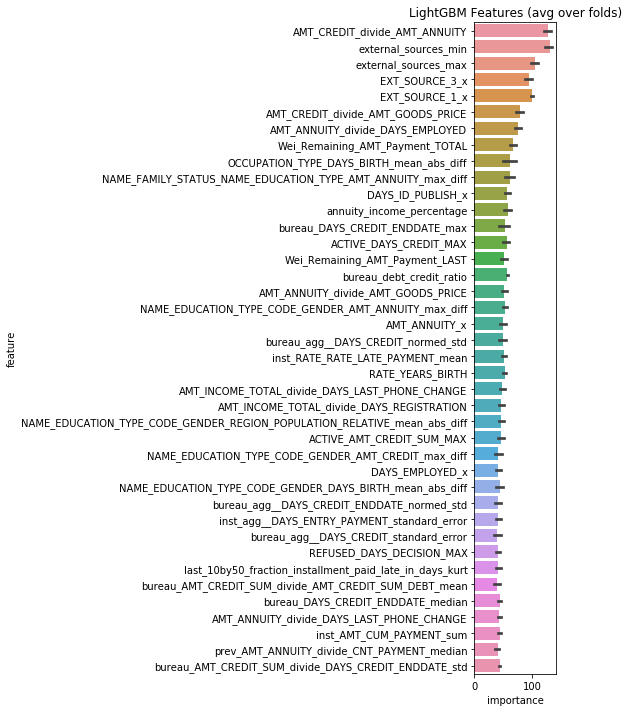

In [30]:
m = kfold_lightgbm(None, train_df, test_bo2[init_feats+['SK_ID_CURR']], holdout_df, 5, 'xgbtest_ridge.csv', 'xgb_rigde_fe_img', True, False, colsample=0.5, lr=0.1, max_depth=5, rounds=None, mode='xgb')

In [72]:
cat_cols = ['creative_is_js', 'model', 'orderid', 'app_id', 'app_cate_id', 'campaign_id', 'creative_tp_dnf', 'ad_i_i_lvl1', 'f_channel', 'time_hour', 'advert_name', 'os_name', 'inner_slot_id', 'creative_is_voicead', 'creative_is_jump', 'app_paid', 'creative_is_download', 'is_shenghuicity', 'creative_id', 'province', 'nnt', 'amt_usertags', 'ad_i_i_lvl2', 'advert_industry_inner', 'city', 'datetime', 'make', 'carrier', 'adid', 'has_usertags', 'os', 'osv', 'time_day', 'user_tags', 'advert_id', 'devtype', 'creative_has_deeplink', 'creative_type']

(1001650, 42) (40024, 43) (157211, 42)
MEAN: train(1001650) vs holdout(157211):  0.19845954175610242 0.20714835475889093
computing optimal rounds...


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's binary_logloss: 0.417708 + 0.000844278
[200]	cv_agg's binary_logloss: 0.418639 + 0.000869352
lgb cv:  0.41741797219389776  std:  0.0008003305255694423
best rounds:  55


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  1 [   55] binary_logloss : ho: 0.415303 / te: 0.416830 / tr: 0.407517 (diff: 0.001527)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  2 [   55] binary_logloss : ho: 0.415289 / te: 0.416427 / tr: 0.407452 (diff: 0.001138)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  3 [   55] binary_logloss : ho: 0.414912 / te: 0.417802 / tr: 0.407312 (diff: 0.002890)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  4 [   55] binary_logloss : ho: 0.415414 / te: 0.417527 / tr: 0.407360 (diff: 0.002113)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  5 [   55] binary_logloss : ho: 0.414891 / te: 0.418441 / tr: 0.407054 (diff: 0.003549)


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Fold  6 [   55] binary_logloss : ho: 0.415071 / te: 0.417339 / tr: 0.407218 (diff: 0.002268)
Full HO score 0.414553
FULL HO mean 0.415147, std 0.000201
FULL TE mean 0.417394, std 0.000650
FULL TR mean 0.407319, std 0.000152
FULL DIFF mean 0.002248, std 0.000804


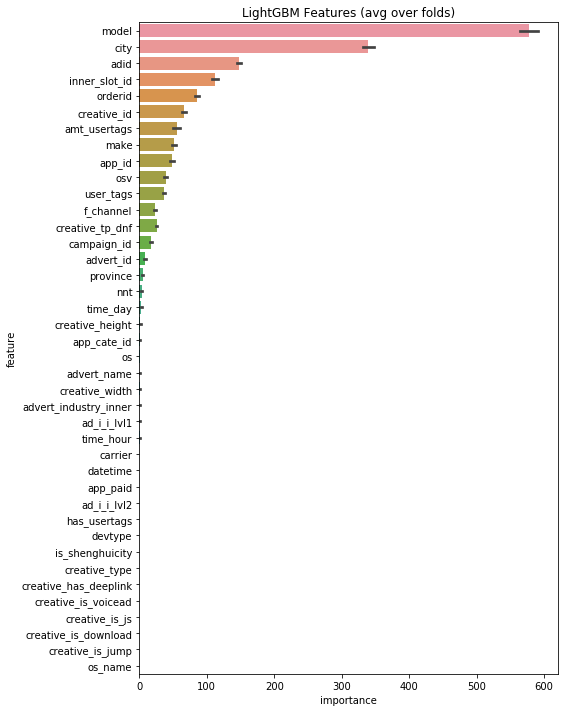

In [99]:
l1 = kfold_lightgbm(None, train_df, test_df, holdout_df, 6, 6, 'lgb_xunfei.csv', 'lgb_xunfei_fe_img', True, False, colsample=1, lr=0.1, max_depth=-1, rounds=None, mode='lgb', cat_cols=cat_cols, break_after_fold1=False, target='click', id_feat='instance_id', metric='binary_logloss', metric_func=log_loss, test_target='predicted_score')

In [93]:
sub = pd.read_csv('lgb_xunfei.csv')

sub.head()

,instance_id,predicted_score
0,6930856710792380886,0.146542
1,5460409694420131920,0.326009
2,982813438159141507,0.103702
3,529991959116679673,0.210140
4,5357053206615171780,0.004132


In [ ]:
Fold  5 [  440] AUC : ho: 0.792424 / te: 0.793129 / tr: 0.875580 (diff: 0.000705)
Full HO score 0.796556
FULL HO mean 0.791801, std 0.000899
FULL TE mean 0.792411, std 0.002417
FULL TR mean 0.875899, std 0.001153
FULL DIFF mean 0.002302, std 0.002114

In [ ]:
441 (lgb init feats)
Full HO score 0.793819
FULL HO mean 0.789294, std 0.000977
FULL TE mean 0.791157, std 0.002599
FULL TR mean 0.868481, std 0.001081
FULL DIFF mean 0.003374, std 0.001955

In [ ]:
370
Full HO score 0.793627
FULL HO mean 0.789108, std 0.000999
FULL TE mean 0.791110, std 0.003125

In [17]:
fe_imp, _, _ = m

fe_imp.shape

feats = (fe_imp.feature.tolist() + list(set(test_bo2.columns) - set(fe_imp.feature)))
feats.remove('TARGET')
len(feats)

train_bo2.shape

In [5]:
import xgboost as xgb

print_to_file = False

from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_xgb(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None, mode='sklearn', max_bin=255):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
        
        
    # compute optimal rounds
    xgb_model = None
    xgb_params = {
        'objective': 'binary:logistic',
#         'boosting': 'gbdt',
        'learning_rate': lr,
        'colsample_bytree': colsample,

#         'max_bin': max_bin,
#         'min_data_in_leaf': min_child_samples,
#         'num_leaves': num_leaves, 
#         'num_threads': 5, 
        'max_depth': max_depth,
#         'min_child_weight': 39,
#         'feature_fraction': colsample,
#         'feature_fraction_seed': seed,
#         'bagging_fraction': subsample, 
#         'bagging_seed': seed,
#         'scale_pos_weight': 1,
#         'lambda_l1': 0.65, 
#         'lambda_l2': reg_lambda,
#         'metric': 'auc'
        'eval_metric': 'auc'
    }
    if rounds is None:
        print('computing optimal rounds...')
        xgb_train = xgb.DMatrix(train_df.drop(columns=['TARGET','SK_ID_CURR']), label=train_df['TARGET'])

        eval_hist = xgb.cv(xgb_params, xgb_train, nfold=num_folds, stratified=stratified,  
                           num_boost_round=50000, early_stopping_rounds=200, verbose_eval=verbose)
        best_round = len(eval_hist['test-auc-mean'])
#         best_round = len(eval_hist['auc-mean'])
        rounds = best_round
#         print('xgb cv: ', eval_hist['auc-mean'][-1], ' std: ', eval_hist['auc-stdv'][-1])
        print('xgb cv te: ', eval_hist['test-auc-mean'].values[-1], ' tr: ', eval_hist['train-auc-mean'].values[-1])
        print('best rounds: ', rounds)

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        if mode=='sklearn':
            clf = xgbMClassifier(
                nthread=18,
                n_estimators=30000,
                learning_rate=lr,
                num_leaves=num_leaves,
                colsample_bytree=colsample, # 0.67
                subsample=subsample,
                subsample_freq=0, ## disable subsampling
                max_depth=max_depth,
                reg_alpha=0.65,
                reg_lambda=reg_lambda,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                min_child_samples=min_child_samples,
                silent=-1,
                verbose=-1, )
            if rounds is not None:
                clf.n_estimators = rounds
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= 'auc', verbose=verbose)
                oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
            else:
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
                oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 

            train_score = clf.best_score_['training']['auc']
         
    
        else:
            xgb_train = xgb.DMatrix(train_x, label=train_y)
            xgb_val = xgb.DMatrix(valid_x, label=valid_y)
            xgb_val_x = xgb.DMatrix(valid_x)
            xgb_test = xgb.DMatrix(test_df[feats])
            xgb_holdout = xgb.DMatrix(holdout[feats])
#             xgb_model = xgb.train(xgb_params, train_set=xgb_train, valid_sets=[xgb_train, xgb_val], 
#                                   num_boost_round=rounds, verbose_eval=verbose)
            xgb_model = xgb.train(xgb_params, xgb_train, evals=[(xgb_val, 'val')], 
                                  num_boost_round=rounds, verbose_eval=verbose)
#             oof_preds[valid_idx] = xgb_model.predict(valid_x)
            oof_preds[valid_idx] = xgb_model.predict(xgb_val_x)
#             sub_preds += xgb_model.predict(test_df[feats]) / folds.n_splits
            sub_preds += xgb_model.predict(xgb_test) / folds.n_splits
#             holdout_preds = xgb_model.predict(holdout[feats])
            holdout_preds = xgb_model.predict(xgb_holdout)
            
            train_score = -1 #xgb_model.best_score['training']['auc'] 
        
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds #if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)

        fold_importance_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
        else:
#             fold_importance_df['feature'] = xgb_model.feature_name() 
#             fold_importance_df["importance"] = xgb_model.feature_importance() 
            fold_importance_df = pd.DataFrame.from_dict(xgb_model.get_fscore(), orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_importance_gain_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_gain_df["feature"] = feats
            fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        else:
#             fold_importance_gain_df['feature'] = xgb_model.feature_name() 
#             fold_importance_gain_df["importance"] = xgb_model.feature_importance(importance_type='gain') 
            fold_importance_gain_df = pd.DataFrame.from_dict(xgb_model.get_fscore(), orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)


#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % roc_auc_score(holdout['TARGET'], holdout_final_preds))
    print('FULL HO mean {:.6f}, std {:.6f}'.format(np.mean(holdout_scores), np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(np.mean(scores), np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(np.mean(train_scores), np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    if not print_to_file:
        display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df, oof_preds 
        
#                 min_split_gain=0.0222415,

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [90]:
from sklearn.metrics import log_loss

import lightgbm as lgb
def kfold_lightgbm(df, train_df, test_df, holdout, cv_folds, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None, mode='sklearn', max_bin=255, cat_cols='auto', break_after_fold1=False, target='TARGET', id_feat='SK_ID_CURR', metric='auc', metric_func=roc_auc_score, test_target='TARGET'):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df[target].mean(), holdout[target].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df[target].notnull()]
        test_df = df[df[target].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
        
        
    # compute optimal rounds
    lgb_params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': lr,
        'max_bin': max_bin,
        'min_data_in_leaf': min_child_samples,
        'num_leaves': num_leaves, 
        'num_threads': 18, 
        'max_depth': max_depth,
        'min_child_weight': 39,
        'feature_fraction': colsample,
        'feature_fraction_seed': seed,
        'bagging_fraction': subsample, 
        'bagging_seed': seed,
        'scale_pos_weight': 1,
        'lambda_l1': 0.65, 
        'lambda_l2': reg_lambda,
#         'device': 'GPU',
        'metric': metric
    }
    if rounds is None:
        print('computing optimal rounds...')
        lgb_train = lgb.Dataset(train_df.drop(columns=[target,id_feat]), label=train_df[target], categorical_feature=cat_cols)

        eval_hist = lgb.cv(lgb_params, lgb_train, nfold=cv_folds, stratified=stratified, 
                           num_boost_round=50000, early_stopping_rounds=200, verbose_eval=verbose)
        best_round = len(eval_hist[metric+'-mean'])
        rounds = best_round
        print('lgb cv: ', eval_hist[metric+'-mean'][-1], ' std: ', eval_hist[metric+'-stdv'][-1])
        print('best rounds: ', rounds)
        
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in [target, id_feat]]#'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    diff_val_holdout = []
    
#     train_all_x = train_df[feats]
#     train_all_y = train_df[target]
    
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[target])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[target].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[target].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))

        if mode=='sklearn':
            clf = LGBMClassifier(
                nthread=18,
                n_estimators=30000,
                learning_rate=lr,
                num_leaves=num_leaves,
                colsample_bytree=colsample, # 0.67
                subsample=subsample,
                subsample_freq=0, ## disable subsampling
                max_depth=max_depth,
                reg_alpha=0.65,
                reg_lambda=reg_lambda,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                min_child_samples=min_child_samples,
                silent=-1,
                verbose=-1, )
            if rounds is not None:
                clf.n_estimators = rounds
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= metric, verbose=verbose)
                oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
            else:
                clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                    eval_metric= metric, verbose=verbose, early_stopping_rounds= 200)
                oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
                sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
                holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 

            train_score = clf.best_score_['training'][metric]
         
    
        else:
#             lgb_params['device'] = 'GPU'
            lgb_train = lgb.Dataset(train_x, label=train_y, categorical_feature=cat_cols)
            lgb_val = lgb.Dataset(valid_x, label=valid_y, categorical_feature=cat_cols)
            lgb_model = lgb.train(lgb_params, train_set=lgb_train, valid_sets=[lgb_train, lgb_val], 
                                  num_boost_round=rounds, verbose_eval=verbose)
            oof_preds[valid_idx] = lgb_model.predict(valid_x)
            sub_preds += lgb_model.predict(test_df[feats]) / folds.n_splits
            holdout_preds = lgb_model.predict(holdout[feats])
            
            train_score = lgb_model.best_score['training'][metric] 
        
        holdout_final_preds += holdout_preds / folds.n_splits
        score = metric_func(valid_y, oof_preds[valid_idx])
        holdout_score = metric_func(holdout[target], holdout_preds)
        diff = abs(score - holdout_score)
        best_rounds = rounds #if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] %s : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, metric, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)

        fold_importance_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
        else:
            fold_importance_df['feature'] = lgb_model.feature_name() 
            fold_importance_df["importance"] = lgb_model.feature_importance() 
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        fold_importance_gain_df = pd.DataFrame()
        if mode=='sklearn':
            fold_importance_gain_df["feature"] = feats
            fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        else:
            fold_importance_gain_df['feature'] = lgb_model.feature_name() 
            fold_importance_gain_df["importance"] = lgb_model.feature_importance(importance_type='gain') 
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)
    
        if break_after_fold1:
            break

#     print('Full AUC score %.6f' % metric_func(train_df[target], oof_preds))
    print('Full HO score %.6f' % metric_func(holdout[target], holdout_final_preds))
    print('FULL HO mean {:.6f}, std {:.6f}'.format(np.mean(holdout_scores), np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(np.mean(scores), np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(np.mean(train_scores), np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df[test_target] = sub_preds
        test_df[[id_feat, test_target]].to_csv(submission_file_name, index= False)
    if not print_to_file:
        display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df, oof_preds
        